# Main capabilities Deep Latent Microbiome 
Notebook describing the main capabilities of the Deep Latent Microbiome system.

Our case of study is the Maize Rhizosphere microbiome, with data from [Walters et al., 2018](https://doi.org/10.1073/pnas.1800918115).

1. [Train model](#BuildModel)
2. [Predictions Test Set](#PredictionsTestSet)
3. [Application to novel samples](#NovelSamples)
4. [Train model with different environmental features](#TrainOtherEnvFeatures)
5. [Train model with different OTUs (aggregation at a higher taxonomic level)](#AggregatedData)
6. [Transfer Learning](#TransferLearning)


#### Import libraries

In [1]:
import sys
sys.path.append('../Src/')
from data import *
from train_2 import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


***

# Train reference model <a name="BuildModel"></a>

### Read datasets
Read OTU table and metadata table and transform to numpy objects.

In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures( \
        metadata_names=['age','Temperature','Precipitation3Days'], \
        otu_filename='../Datasets/otu_table_all_80.csv', \
        metadata_filename='../Datasets/metadata_table_all_80.csv')

In [3]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

### Train an Autoencoder model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

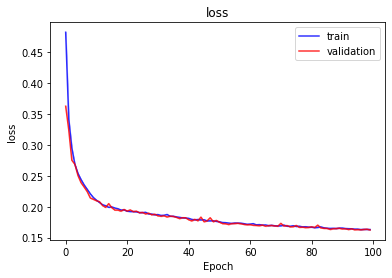

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

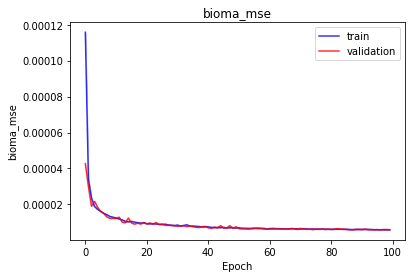

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

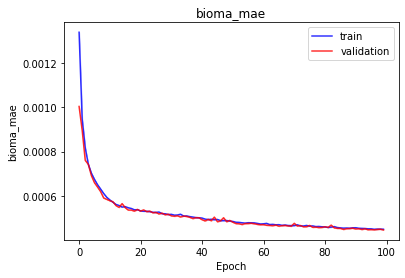

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

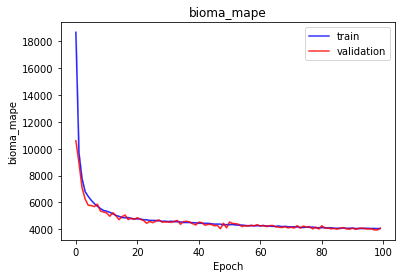

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

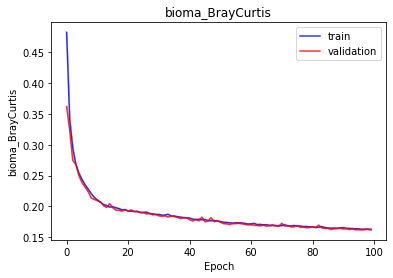

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

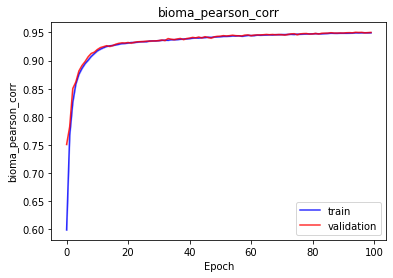

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

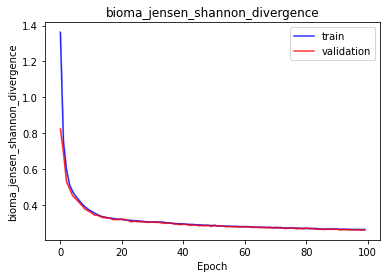

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [4]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

In this example a OTU latent space is trained. 
To train a combined latent space: `data_domain_train=data_domain_train`

When the model is being evaluated to define the hyperparameters, cv_folds=5. Once hyperparameters are selected, the autoencoder is built with the entire training set.

### Save encoders and decoders

In [5]:
model, encoder, _ ,decoder = models[0]

The decoder would be the second module of the predictor model (latent space --> microbial composition).

The third model would be the encoder from environmental features, that does not exist in this case, because a OTU latent space was trained. 

### Build model to predict latent space from environmental features 
To define the architecture of the first module of the predictor model (environmental features --> latent space).

In [6]:
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

#### Train the latent space predictor

In [7]:
latent_train = encoder.predict(data_microbioma_train)
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

#### Evaluate the model over the test set

In [8]:
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4181441366672516 | 0.4181441366672516 | 0.4181441366672516 |
| pearson_corr | 0.7348228096961975 | 0.7348228096961975 | 0.7348228096961975 |
| jensen_shannon_divergence | 0.8599598407745361 | 0.8599598407745361 | 0.8599598407745361 |


### Save models

In [9]:
encoder.save('../Results/Models/encoder_biome.h5')
decoder.save('../Results/Models/decoder.h5')
model_latent.save('../Results/Models/encoder_domain_model_latent.h5')

In [10]:
encoder_biome = encoder
encoder_domain = model_latent

***

# Predictions test set <a name="PredictionsTestSet"></a>

#### Save predictions in files for external use (R plots)

In [11]:
df_microbioma_test.T.to_csv('../Results/otus_original_test.tsv', index=True, header=True, sep='\t')

In [12]:
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('../Results/otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('../Results/latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

#### Run prediction test set from microbiome, i.e. reconstructed

In [13]:
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

In [14]:
_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome')

#### Run prediction test set from domain (i.e. environmental features)

In [15]:
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)

In [16]:
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain')

***

# Application to novel samples: prediction of novel ecosystems <a name="NovelSamples"></a>
To predict microbiome for new environmental features.

To load the environmental feature values (in this case, plant age, temperature and precipitation) from a .csv file.

In [17]:
metadata = pd.read_csv('../Datasets/NovelEcosystems/metadata_novel_samples_only3envFeatures.csv', sep='\t')
metadata = metadata.set_index('X.SampleID')
domain = metadata[['age',
                   'Temperature',
                   'Precipitation3Days']]
print(domain.shape)


(48, 3)


In [18]:
domain_novel_samples = domain.to_numpy(dtype=np.float32)

#### Load models (previously trained)
* First module: encoder_domain (environmental features --> latent space)

In [19]:
encoder_domain = tf.keras.models.load_model('../Results/Models/encoder_domain_model_latent.h5')

* Second module: decoder (latent space --> microbial composition)

In [20]:
decoder = tf.keras.models.load_model('../Results/Models/decoder.h5')

#### Compute new predictions

In [21]:
# Input only domain (i.e. environmental features)
pred_latent_novel_samples = encoder_domain.predict(domain_novel_samples)
pred_domain_novel_samples = decoder.predict(pred_latent_novel_samples)

In [22]:
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain_novel_samples,pred_latent_novel_samples,domain.index,df_microbioma_test.columns,'predFromDomain_novelSamples')

***

# Train model with different environmental features <a name="TrainOtherEnvFeatures"></a>
The only difference with the procedure described above, is to call the generic read dataset function (`read_df_with_transfer_learning_subset_fewerDomainFeatures()`) with different parameters. For example, just `['Temperature']` rather than `['age','Temperature','Precipitation3Days']`

In [23]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures( \
        metadata_names=['age','Temperature','Precipitation3Days'], \
        otu_filename='../Datasets/otu_table_all_80.csv', \
        metadata_filename='../Datasets/metadata_table_all_80.csv')

The rest of the steps for training the model is the the same as described above, in the [Train model](#BuildModel) section.

***

# Train model with different OTUs (aggregation at a higher taxonomic level) <a name="AggregatedData"></a>
The only difference with the procedure for training the model with OTU at species level, is to call a different function to read the otu table: `read_df_with_transfer_learning_subset_fewerDomainFeatures()`

In [24]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures( \
        metadata_names=['age','Temperature','Precipitation3Days'],
        otu_filename='../Datasets/Aggregated/otu_table_Family.csv',
        metadata_filename='../Datasets/Aggregated/metadata_table_all_80.csv')

The OTU table should be previously aggregated at a higher taxonomic level, using the R scripts `Src/aggregating_taxonomic_levels.r`.
The metadata file is the same.

The rest of the steps for training the model is the the same as described above, in the [Train model](#BuildModel) section.

***

# Transfer Learning <a name="TransferLearning"></a>
This section explains how to re-use a model trained with sufficient samples (large dataset, such as [Walters et al.](https://doi.org/10.1073/pnas.1800918115) used until now) in a different but similar scenario where there are too few samples to undertake training (small dataset, such as [Maarastawi et al.](https://dx.doi.org/10.3389%2Ffmicb.2018.01295)).

Here we explains the differences with the entire pipeline described above in the [Train model](#BuildModel) section.

### Read datasets
Read data with a call to a different functions, that allow to read two different datasets (the large and the small one), defining the environmental features to read from the metadata files.

In [25]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_2otufiles_differentDomainFeatures(
              metadata_names=['age','Temperature','Precipitation3Days'],
              otu_filename='../Datasets/Aggregated/otu_table_Phylum.csv',
              metadata_filename='../Datasets/Aggregated/metadata_table_all_80.csv',
              metadata_names_transfer=['pH','N', 'C', 'C.N'],
              otu_transfer_filename='../Datasets/Maarastawi2018/otu_table_Phylum_Maarastawi2018.csv',
              metadata_transfer_filename='../Datasets/Maarastawi2018/metadata_table_Maarastawi2018.csv')

data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

Note that both otu files (`otu_filename` and `otu_transfer_filename`) must be defined at the same taxonomic levels, in this case, Phylum.

### Train an Autoencoder model
This autoencoder must be re-built, with the same code than [above](#BuildModel), but with a different datasets, with less OTUs, at Phylum level.

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.0202 (min: 0.0202, max: 0.0202)

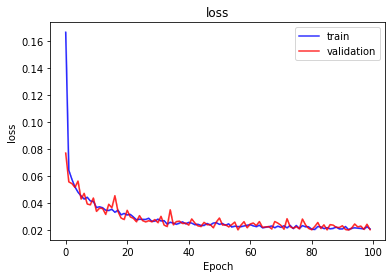

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

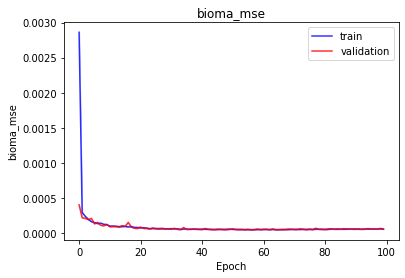

<b>bioma_mae</b>: 0.0023 (min: 0.0023, max: 0.0023)

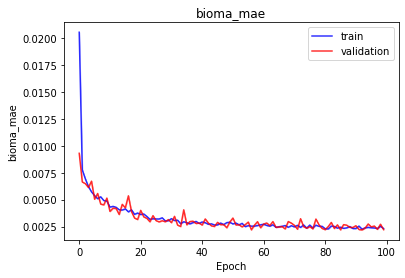

<b>bioma_mape</b>: 34815.7500 (min: 34815.7500, max: 34815.7500)

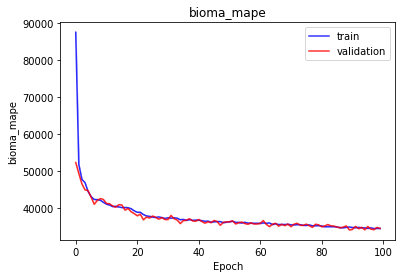

<b>bioma_BrayCurtis</b>: 0.0202 (min: 0.0202, max: 0.0202)

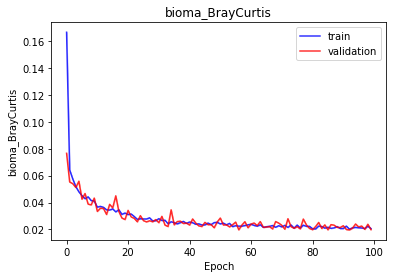

<b>bioma_pearson_corr</b>: 0.9951 (min: 0.9951, max: 0.9951)

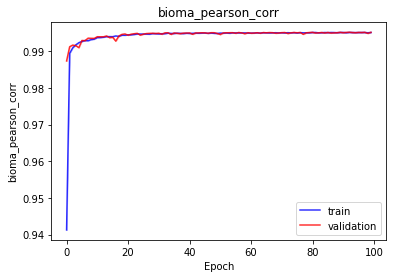

<b>bioma_jensen_shannon_divergence</b>: 0.0379 (min: 0.0379, max: 0.0379)

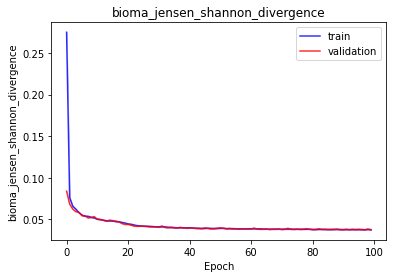

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.020192634209138707 | 0.020192634209138707 | 0.020192634209138707 |
| bioma_mse | 5.392134335124865e-05 | 5.392134335124865e-05 | 5.392134335124865e-05 |
| bioma_mae | 0.0022594642359763384 | 0.0022594642359763384 | 0.0022594642359763384 |
| bioma_mape | 34815.75 | 34815.75 | 34815.75 |
| bioma_BrayCurtis | 0.02019263431429863 | 0.02019263431429863 | 0.02019263431429863 |
| bioma_pearson_corr | 0.9951272010803223 | 0.9951272010803223 | 0.9951272010803223 |
| bioma_jensen_shannon_divergence | 0.037871796637773514 | 0.037871796637773514 | 0.037871796637773514 |


*************

In [26]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')
model, encoder, _ ,decoder = models[0]

### Build model to predict latent space from environmental features 
In this case, this first module of the predictor model (environmental features --> latent space) must build based on the transfer learning datasets, using the variable `data_domain_transfer_learning_train` 

In [27]:
def model_fn_tl():
    in_layer = layers.Input(shape=(data_domain_transfer_learning_train.shape[1],))  
    net = layers.Dense(64, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)  
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

#### Train the latent space predictor

In [28]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

#### Evaluate the model over the test set
Environmental features --> latent space --> microbial composition

In [29]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.32325273752212524 | 0.32325273752212524 | 0.32325273752212524 |
| pearson_corr | 0.7654317021369934 | 0.7654317021369934 | 0.7654317021369934 |
| jensen_shannon_divergence | 1.0472432374954224 | 1.0472432374954224 | 1.0472432374954224 |
